<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-to-morphological-image-processing" data-toc-modified-id="Introduction-to-morphological-image-processing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction to morphological image processing</a></span><ul class="toc-item"><li><span><a href="#Binary-morphology" data-toc-modified-id="Binary-morphology-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Binary morphology</a></span><ul class="toc-item"><li><span><a href="#Erosion-&amp;-Dilation" data-toc-modified-id="Erosion-&amp;-Dilation-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Erosion &amp; Dilation</a></span></li><li><span><a href="#Compound-operations:-opening-&amp;-closing" data-toc-modified-id="Compound-operations:-opening-&amp;-closing-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Compound operations: opening &amp; closing</a></span></li></ul></li><li><span><a href="#Grayscale-operations" data-toc-modified-id="Grayscale-operations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Grayscale operations</a></span><ul class="toc-item"><li><span><a href="#Reconstruction" data-toc-modified-id="Reconstruction-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Reconstruction</a></span></li></ul></li></ul></li></ul></div>

# Introduction to morphological image processing

A technique based on the concepts of *mathematical morphology* (MM), which analyses geometrical structures based on set theory and topology. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from skimage import data, morphology, img_as_float, measure, filters, transform, exposure, restoration, feature

%config InlineBackend.figure_format = 'retina'
%matplotlib Inline

mpl.rcParams['image.cmap'] = 'Greys'    
mpl.rcParams['font.size'] = 9
mpl.rcParams['font.family'] = 'Liberation Sans'

## Binary morphology

The underlying principles of MM are best understood in the context of binary images, i.e. those where a pixel is either equal to 1 or 0. Below we generate such an image via the `skimage.data` module:

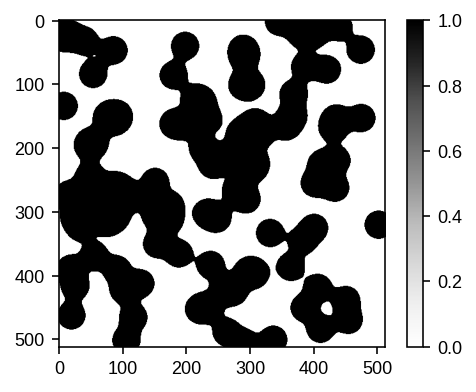

In [2]:
blobs = data.binary_blobs(seed=10)

plt.figure(figsize=(4,3))
plt.imshow(blobs)
plt.colorbar();

Next, we define a *structuring element* (SE). This is a kernel which will be convoluted with the image to be analysed - here the "blobs" plotted above. We define an SE as a disk of radius equal to 5 pixels:

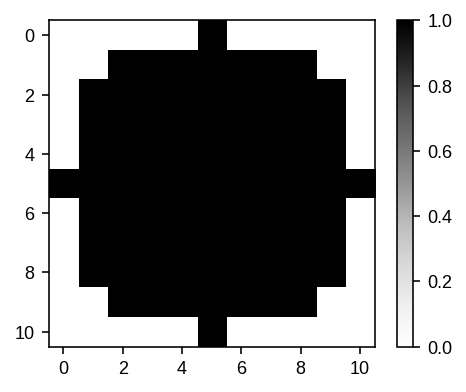

In [3]:
SE = morphology.selem.disk(5)

plt.figure(figsize=(4,3))
plt.imshow(SE)
plt.colorbar();

The centre of the SE will be placed on each pixel of the "blobs" image. The value of this image pixel will be compared to that of those pixels falling within the rest of the SE. A chosen mathematical operation then outputs a result binary image based on this comparison.

### Erosion & Dilation

The simplest of these operations are *erosion* and *dilation*. 

Erosion yields an image containing only features which "fit" in the chosen SE: anything else is given a value of 0. Features (here, "blobs") in the resulting image thus appear "thinner". This operation can be used to remove small isolated features from an image.

Dilation does the opposite: it produces a new binary image with ones at all locations of the SE origin at which the SE hits a pixel equal to 1 in the original image. Thus, features in the resulting image appear "thickened".


Erosion of the dark blue square by a disk, yielding the light blue square | Dilation  of the dark blue square by a disk, yielding the light blue square
:--------:| :--------:
![Erosion](Erosion.png) | ![Dilation](Dilation.png)

The following demonstrates this:

In [4]:
# erosion
blobs_eroded = morphology.binary_erosion(blobs, selem=SE)

# dilation
blobs_dilated = morphology.binary_dilation(blobs, selem=SE)

# morphological gradient: logical XOR , dilation-erosion
morpho_gradient = blobs_dilated ^ blobs_eroded  

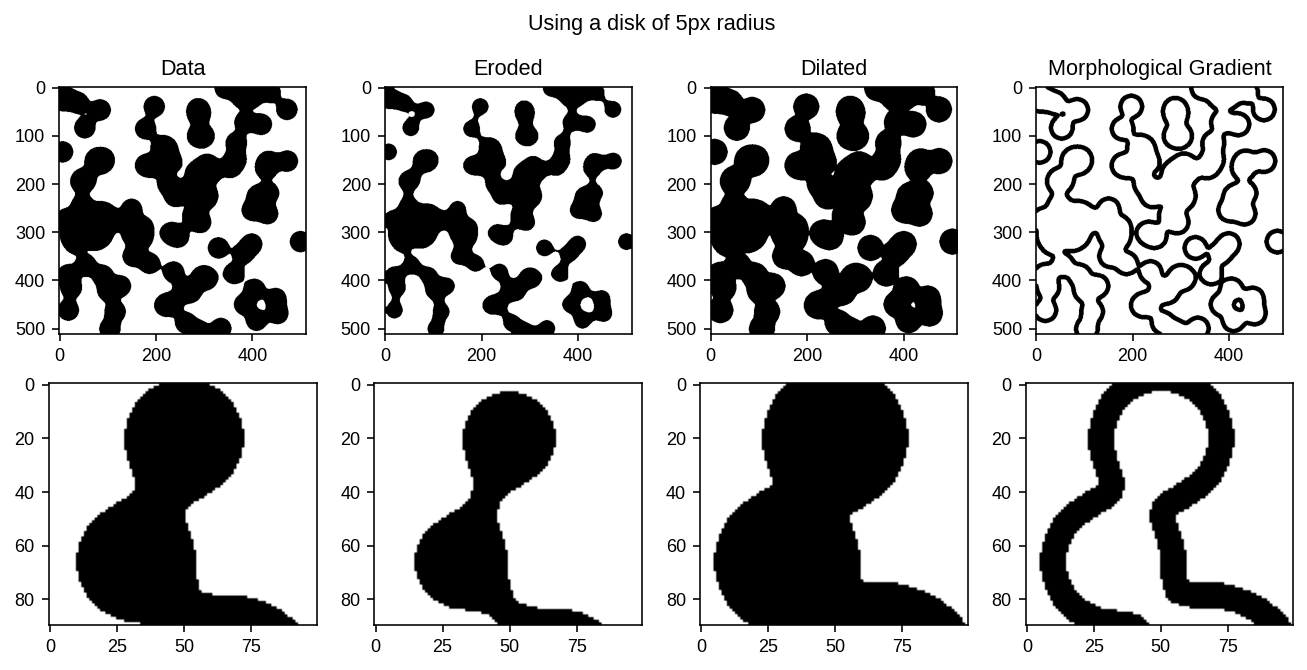

In [6]:
imgs = [blobs, blobs_eroded, blobs_dilated, morpho_gradient]
names = 'Data,Eroded,Dilated,Morphological Gradient'.split(',')

fig, axes = plt.subplots(2,4, constrained_layout=True, figsize=(9,4.5))
fig.suptitle('Using a disk of 5px radius')

for ax, topl, name in zip(axes[0,:], imgs, names):
    ax.imshow(topl)
    ax.set_title(name)

for ax, topl in zip(axes[1,:],imgs):
    ax.imshow(topl[20:110,147:247])

Above we have also included the *morphological gradient*: the boolean subtraction of the eroded image from the dilated image, yielding the boundaries of the original features.

### Compound operations: opening & closing

Most morphological functions are a combination of erosion, dilation, and simple operations from set theory (interesections, unions, ...). 

The **opening** of an image by a SE consists of an erosion followed by a dilation. This will "open up" gaps between features separated by thin bridges of pixels.

The **closing** of an image is the opposite, i.e. a dilation followed by an erosion. It will fill holes within features.

Opening | Closing
:------:| :-----:
![Opening](Opening.png) | ![Closing](Closing.png)

The effect of opening and closing is apparent if applied to our "blobs" image:

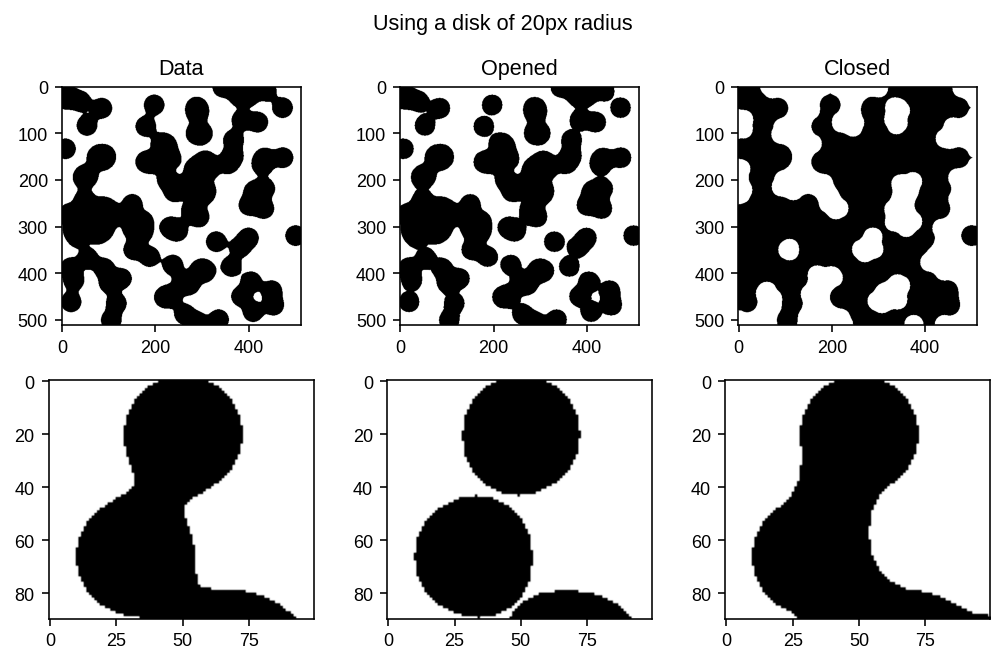

In [7]:
# SE
radius = 20
selem = morphology.selem.disk(radius)

# opening
blobs_opened = morphology.binary_opening(blobs, selem=selem)

# closing
blobs_closed = morphology.binary_closing(blobs, selem=selem)

# plot
imgs = [blobs, blobs_opened, blobs_closed]
names = 'Data,Opened,Closed'.split(',')

fig, axes = plt.subplots(2,3, constrained_layout=True, figsize=(7,4.5))
fig.suptitle('Using a disk of {}px radius'.format(radius))

for ax, topl, name in zip(axes[0,:], imgs, names):
    ax.imshow(topl)
    ax.set_title(name)

for ax, topl in zip(axes[1,:],imgs):
    ax.imshow(topl[20:110,147:247])

## Grayscale operations

In [8]:
mpl.rcParams['image.cmap'] = 'turbo'

The same principles described above can be applied to grayscale images, i.e. those where each pixel can have a value from 0 to N. Normally to be treated by MM these images have to be normalised in the [0,1] range. This is the case for `skimage`.

### Reconstruction

An important greayscale MM opration is **reconstruction by dilation**. This works in the following way:
* A "seed" image is produced by subtracting a certain value to the original image. 
* The dilation of the seed image is performed.
* The dilated image is dilated again iteratively until the size of the dilated features matches that of the original image.

The figure below illustrates this process:

![test](https://fr.mathworks.com/help/images/morph5.gif)

Here we perform such procedure and subtract the reconstructed image from the original, thus isolating the features from the background. The latter is known as the *h-dome* of the original image. The synthetic image consists of two noisy gaussians.

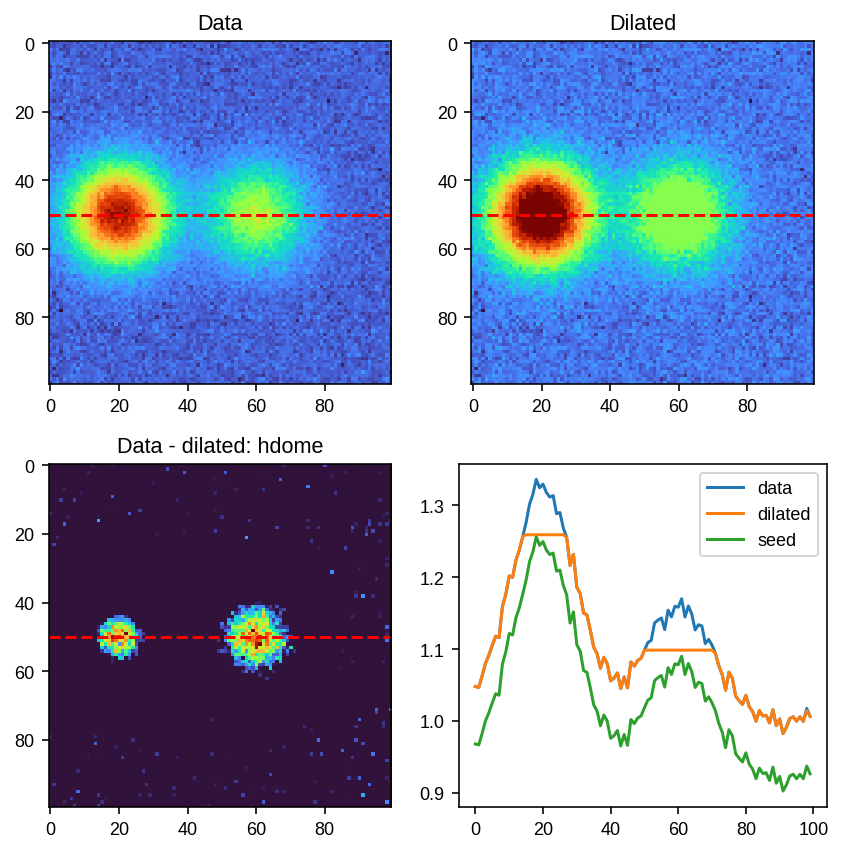

In [9]:
# make image
synth = np.zeros((100,100))
synth[50,60] = 100
synth[50,20] = 200
synth = filters.gaussian(synth, sigma=10)

# add noise
noise = np.random.normal(1, 1e-2, size=synth.size)
noised_img = synth + noise.reshape(synth.shape) 

# reconstruct noisy img
seed = noised_img - 0.08
dilated = morphology.reconstruction(seed, noised_img, selem=morphology.selem.disk(5), method='dilation')
hdome = noised_img - dilated

# plot
fig, ax = plt.subplots(2,2, figsize=(6,6))
ax = ax.flatten()

ax[0].imshow(noised_img)
ax[0].set_title('Data')

ax[1].imshow(dilated)
ax[1].set_title('Dilated')

ax[2].imshow(hdome)
ax[2].set_title('Data - dilated: hdome')

ax[3].plot(noised_img[50], label='data')
ax[3].plot(dilated[50], label='dilated')
ax[3].plot(seed[50], label='seed')
ax[3].legend()

for a in ax[:3]:
    a.axhline(50, c='r', ls='--')
    
fig.tight_layout()

The h-dome image can be used for further processing, such as finding the position of regional maxima:

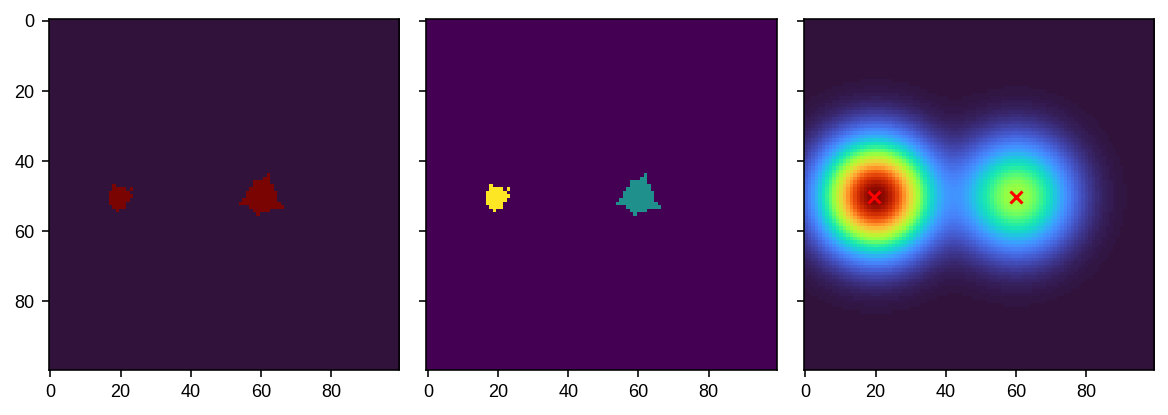

In [10]:
from scipy.ndimage import center_of_mass

# threshold
hdome_ts = hdome > .05

# close thresholded image --> fill gaps if there
hdome_ts_closed = morphology.closing(hdome_ts, selem=morphology.selem.disk(5))

# label and get properties of labelled regions
labels = measure.label(hdome_ts_closed)
region_props = measure.regionprops(labels)

# plot
fig, ax = plt.subplots(1,3, figsize=(8,3), constrained_layout=True, sharex=True, sharey=True)

ax[0].imshow(hdome_ts_closed)
ax[1].imshow(labels, cmap='viridis')
ax[2].imshow(synth)
[ax[2].scatter(r.centroid[1], r.centroid[0], c='r', marker='x') for r in region_props]

Note how the procedure yields the correct centroid for the **original** noise-free image with half a pixel.